# LAB 4. CONSTRAINED OPTIMIZATION: EQUALITY CONSTRAINTS

## 2. SEQUENTIAL QUADRATIC PROGRAMMING

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_contour_gradients(f, gradf, xr=(-1,1.05) ,yr=(-1,1.05), step=0.05):
    # Clear plot
    plt.clf()
    
    # Create a mesh grid and apply the function over all the pairs of points
    X = np.arange(*xr, step)
    Y = np.arange(*yr, step)
    X, Y = np.meshgrid(X, Y)
    
    XY = np.c_[X.ravel(), Y.ravel()]
    Z = np.apply_along_axis(f, 1, XY).reshape(X.shape)

    # Plot contour of the function
    plt.figure()
    plt.contour(X, Y, Z, 50)

    # Get the gradient for each pair of points
    grad=np.apply_along_axis(gradf, 1, XY)
    
    # Plot the gradient
    plt.streamplot(X, Y, grad[:, 0].reshape(X.shape), grad[:, 1].reshape(X.shape))
    
    plt.show()

Let us define the functions that we will use to solve the problem:

In [3]:
def f(x):
    return np.e**(3 * x[0]) + np.e**(-4 * x[1])

def h(x):
    return x[0]**2 + x[1]**2 - 1

def laplacian(x, lamb):
    return f(x) - lamb * h(x)

def grad_f(x):
    return np.array([3 * np.e**(3 * x[0]), -4 * np.e**(-4 * x[1])])

def grad_h(x):
    return np.array([2 * x[0], 2 * x[1]])

def grad_laplacian(x, lamb):
    return grad_f(x) - lamb * grad_h(x)

def hessian_f(x):
    return np.array([[9 * np.e**(3 * x[0]), 0], [0, 16 * np.e**(-4 * x[1])]])

def hessian_h():
    return np.array([[2, 0], [0, 2]])

def hessian_laplacian(x, lamb):
    return hessian_f(x) - lamb * hessian_h()

First, we are going to plot the function that we are aiming to minimize:

<Figure size 432x288 with 0 Axes>

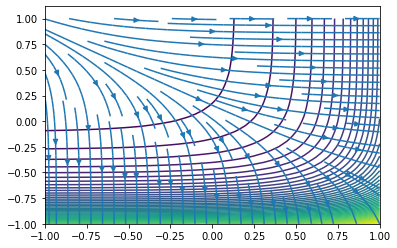

In [4]:
plot_contour_gradients(f, grad_f)

In [5]:
def construct_linear_system(x, lamb):
    leq_matrix = np.zeros((3, 3))
    
    der_h = grad_h(x)
    
    leq_matrix[:-1, :-1] = hessian_laplacian(x, lamb)
    leq_matrix[-1, :-1] = -der_h
    leq_matrix[:-1, -1] = -der_h
    
    rh_vector = np.zeros(3)
    
    rh_vector[:-1] = -grad_laplacian(x, lamb)
    rh_vector[-1] = h(x)
    
    return leq_matrix, rh_vector

In [6]:
def qop(x_0, lamb_0, alpha=1, epsilon=1e-5):
    x = np.copy(x_0)
    lamb = lamb_0
    
    x_path = [x]
    lamb_path = [lamb]
    
    while np.linalg.norm(grad_laplacian(x, lamb)) >= epsilon:
        leq_matrix, rh_vector = construct_linear_system(x, lamb)
        
        v_dir = np.linalg.solve(leq_matrix, rh_vector)
        
        x = x + alpha * v_dir[:-1]
        lamb += alpha * v_dir[-1]
        
        x_path.append(x)
        lamb_path.append(lamb)
        
    return x, lamb, np.array(x_path), np.array(lamb_path)

### Exercise 1

Let's check if we can get the given solution to this problem.

$$x_1^*, x_2^* = (-0.74834, 0.66332)^T$$
$$\lambda^* = -0.21233$$

In [7]:
x = np.array([-1., 1.])
lamb = -1

In [8]:
x_end, lamb_end, _, _ = qop(x, lamb)

print(x_end, lamb_end)

[-0.74833818  0.66332345] -0.21232390186241443


Success!  👍

### Exercise 2

In [9]:
def plot_path(f, path, xr=(-5,1.05), yr=(-1.1,1.05), step=0.05, optimal=(-0.74834,0.66332)):
    # Clear plot
    plt.clf()
    
    # Create a mesh grid and apply the function over all the pairs of points
    X = np.arange(*xr, step)
    Y = np.arange(*yr, step)
    X, Y = np.meshgrid(X, Y)
    
    XY = np.c_[X.ravel(), Y.ravel()]
    Z = np.apply_along_axis(f, 1, XY).reshape(X.shape)

    # Plot contour of the function
    plt.figure()
    plt.contour(X, Y, Z, 50)
    
    # Plot optimal solution along with path to it
    plt.plot(path[:, 0], path[:, 1], 'ko-', label='Path')
    plt.scatter(optimal[0], optimal[1], c='orange', marker='*', label='Optimal')
    
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

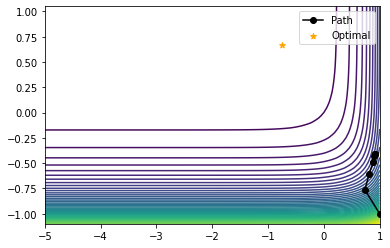

Starting point: [ 1. -1.]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -1	Final lambda: 25.293855202685933


<Figure size 432x288 with 0 Axes>

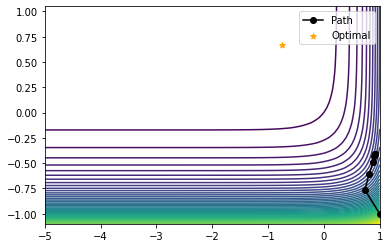

Starting point: [ 1. -1.]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -0.21232390186241443	Final lambda: 25.29385520271043


<Figure size 432x288 with 0 Axes>

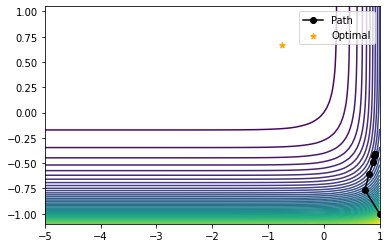

Starting point: [ 1. -1.]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: 2	Final lambda: 25.293855202777692


<Figure size 432x288 with 0 Axes>

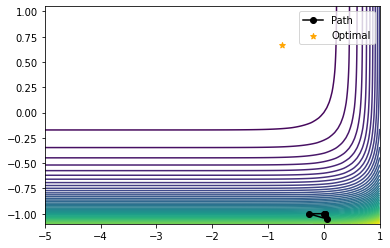

Starting point: [ 0. -1.]	Final point: [ 0.01434523 -0.9998971 ]
Starting lambda: -1	Final lambda: 109.16259801290026


<Figure size 432x288 with 0 Axes>

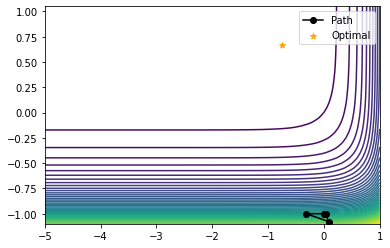

Starting point: [ 0. -1.]	Final point: [ 0.01434523 -0.9998971 ]
Starting lambda: -0.21232390186241443	Final lambda: 109.16259756189065


<Figure size 432x288 with 0 Axes>

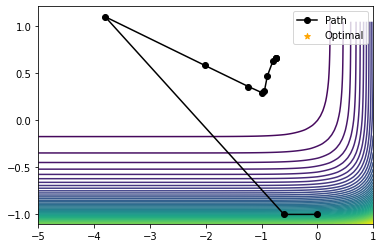

Starting point: [ 0. -1.]	Final point: [-0.74833549  0.66332044]
Starting lambda: 2	Final lambda: -0.21232493446893563


<Figure size 432x288 with 0 Axes>

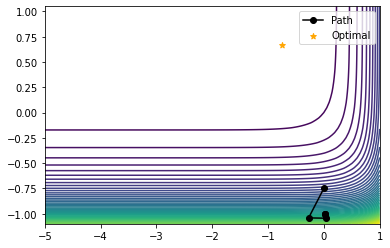

Starting point: [ 0.   -0.75]	Final point: [ 0.01434523 -0.9998971 ]
Starting lambda: -1	Final lambda: 109.1625976096965


<Figure size 432x288 with 0 Axes>

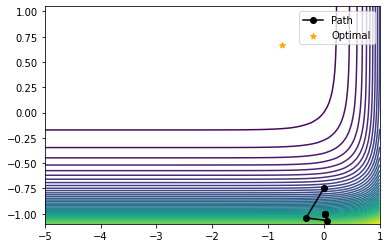

Starting point: [ 0.   -0.75]	Final point: [ 0.01434522 -0.99989712]
Starting lambda: -0.21232390186241443	Final lambda: 109.1626012724059


<Figure size 432x288 with 0 Axes>

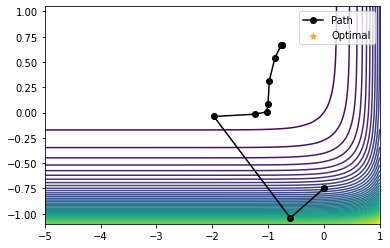

Starting point: [ 0.   -0.75]	Final point: [-0.74833589  0.6633201 ]
Starting lambda: 2	Final lambda: -0.21232469031790208


<Figure size 432x288 with 0 Axes>

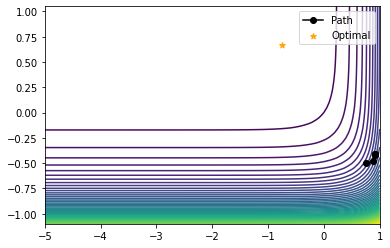

Starting point: [ 0.75 -0.5 ]	Final point: [ 0.91041323 -0.41370006]
Starting lambda: -1	Final lambda: 25.29385520417346


<Figure size 432x288 with 0 Axes>

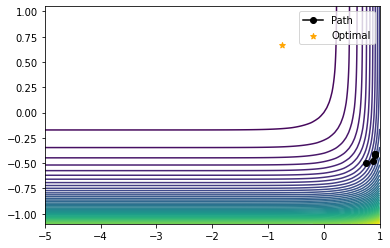

Starting point: [ 0.75 -0.5 ]	Final point: [ 0.91041323 -0.41370006]
Starting lambda: -0.21232390186241443	Final lambda: 25.29385520417471


<Figure size 432x288 with 0 Axes>

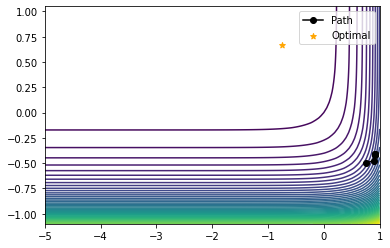

Starting point: [ 0.75 -0.5 ]	Final point: [ 0.91041323 -0.41370006]
Starting lambda: 2	Final lambda: 25.29385520417786


<Figure size 432x288 with 0 Axes>

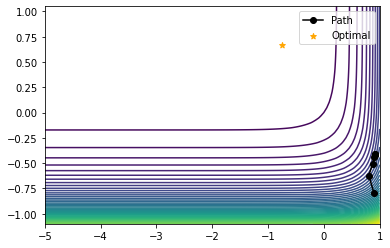

Starting point: [ 0.9 -0.8]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -1	Final lambda: 25.293855187987205


<Figure size 432x288 with 0 Axes>

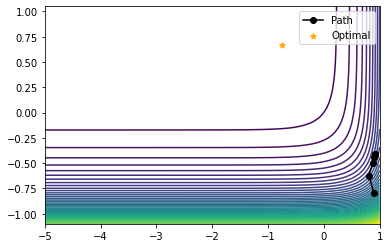

Starting point: [ 0.9 -0.8]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: -0.21232390186241443	Final lambda: 25.293855188679427


<Figure size 432x288 with 0 Axes>

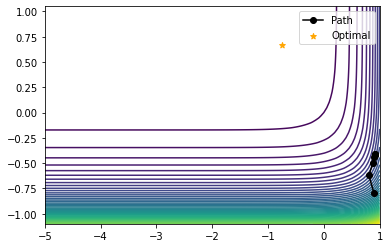

Starting point: [ 0.9 -0.8]	Final point: [ 0.91041323 -0.41370007]
Starting lambda: 2	Final lambda: 25.29385519050294


In [10]:
x_list = np.array([[1., -1.], [0., -1.], [0., -0.75], [0.75, -0.5], [0.9, -0.8]])
lamb_list = [-1, -0.21232390186241443, 2]

for x_0 in x_list:
    for lamb_0 in lamb_list:
        x_end, lamb_end, x_path, _ = qop(x_0, lamb_0)
        plot_path(f, x_path)
        print(f'Starting point: {x_0}\tFinal point: {x_end}')
        print(f'Starting lambda: {lamb_0}\tFinal lambda: {lamb_end}')

There's no solution for $x_1, x_2 = (0, 0)$ because the linear system cannot be solved at that point (it's a singular matrix).

### Exercise 3

In [11]:
def merit(x, rho=10):
    return f(x) + rho * h(x)


def grad_merit(x, rho=10):
    return grad_f(x) + 2 * rho * h(x) * grad_h(x)

In [12]:
def gradient_descent(x_0, g, grad_g, rho=10, tol=1e-5, normalize=False):
    x = x_0
    x_path = [x]
    alpha = 0.001
    
    while np.linalg.norm(grad_g(x, rho)) >= tol:        
        grad_g_val = grad_g(x, rho)
        
        if normalize:
            grad_g_val /= np.linalg.norm(grad_g_val)
        
        x = x - alpha * grad_g_val
        x_path.append(x)
    
    return x, x_path

The normalization of the gradient made it really hard to converge to a value near the optimal. Therefore, we haven't applied it.

<Figure size 432x288 with 0 Axes>

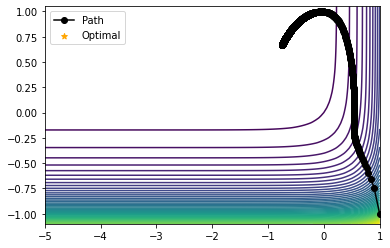

Starting point: [ 1. -1.]	Final point: [-0.75242478  0.66654823]


<Figure size 432x288 with 0 Axes>

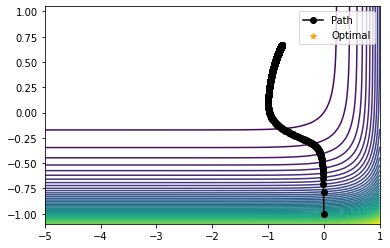

Starting point: [ 0. -1.]	Final point: [-0.7524339   0.66653795]


<Figure size 432x288 with 0 Axes>

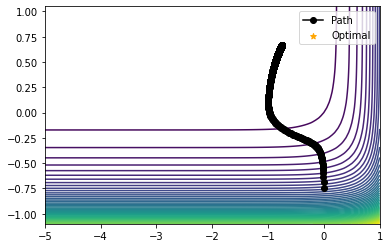

Starting point: [ 0.   -0.75]	Final point: [-0.7524339   0.66653796]


<Figure size 432x288 with 0 Axes>

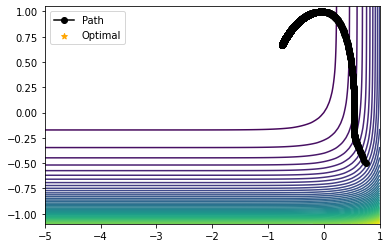

Starting point: [ 0.75 -0.5 ]	Final point: [-0.75242477  0.66654823]


<Figure size 432x288 with 0 Axes>

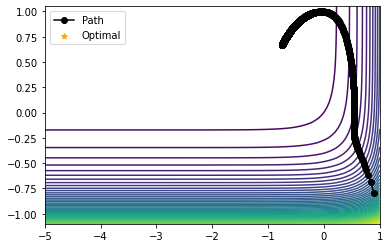

Starting point: [ 0.9 -0.8]	Final point: [-0.75242478  0.66654823]


In [13]:
for x_0 in x_list:
    x_end, x_path = gradient_descent(x_0, merit, grad_merit)
    plot_path(f, np.array(x_path))
    print(f'Starting point: {x_0}\tFinal point: {x_end}')

### Exercise 4

In [14]:
def plot_combined_path(f, merit_path, newton_path, xr=(-5,1.05), yr=(-1.1,1.05),
                       step=0.05, optimal=(-0.74834,0.66332)):
    # Clear plot
    plt.clf()
    
    # Create a mesh grid and apply the function over all the pairs of points
    X = np.arange(*xr, step)
    Y = np.arange(*yr, step)
    X, Y = np.meshgrid(X, Y)
    
    XY = np.c_[X.ravel(), Y.ravel()]
    Z = np.apply_along_axis(f, 1, XY).reshape(X.shape)

    # Plot contour of the function
    plt.figure()
    plt.contour(X, Y, Z, 50)
    
    # Plot optimal solution along with paths to it
    plt.plot(merit_path[:, 0], merit_path[:, 1], 'ro-', label='Merit')
    plt.plot(newton_path[:, 0], newton_path[:, 1], 'bo-', label='Newton')
    plt.scatter(optimal[0], optimal[1], c='orange', marker='*', label='Optimal')
    
    plt.legend()
    plt.show()    

In [15]:
def qop_merit(x_0, lamb_0, g, grad_g, rho=10, tol=1e-5, normalize=False):
    x, x_path_merit = gradient_descent(x_0, g, grad_g, rho, tol, normalize)
    x, lamb, x_path_qop, lamb_path = qop(x, lamb_0, epsilon=tol)
    
    return x, lamb, np.array(x_path_merit), np.array(x_path_qop), lamb_path

<Figure size 432x288 with 0 Axes>

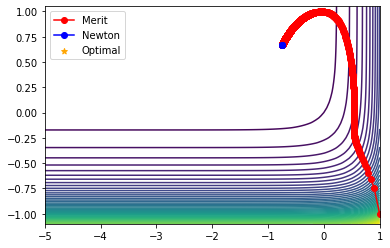

Starting point: [ 1. -1.]	Final point: [-0.74833606  0.66331981]
Starting lambda: -1	Final lambda: -0.21232500268673524


<Figure size 432x288 with 0 Axes>

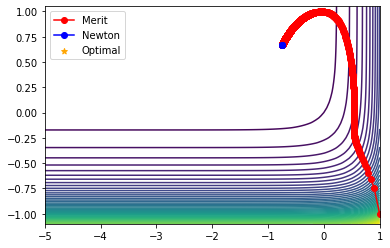

Starting point: [ 1. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501483163


<Figure size 432x288 with 0 Axes>

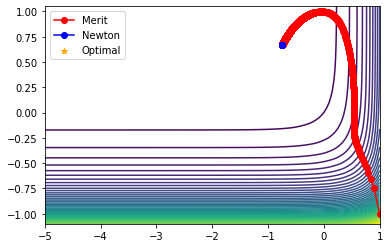

Starting point: [ 1. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.21232493550295337


<Figure size 432x288 with 0 Axes>

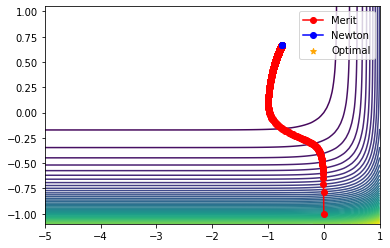

Starting point: [ 0. -1.]	Final point: [-0.74833608  0.66331978]
Starting lambda: -1	Final lambda: -0.21232500215661493


<Figure size 432x288 with 0 Axes>

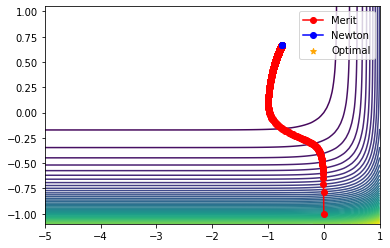

Starting point: [ 0. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501505165


<Figure size 432x288 with 0 Axes>

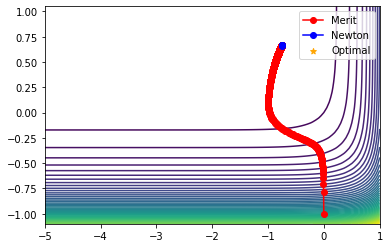

Starting point: [ 0. -1.]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.21232493549853332


<Figure size 432x288 with 0 Axes>

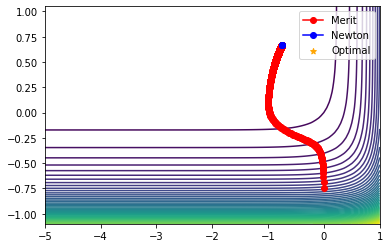

Starting point: [ 0.   -0.75]	Final point: [-0.74833608  0.66331978]
Starting lambda: -1	Final lambda: -0.21232500215678607


<Figure size 432x288 with 0 Axes>

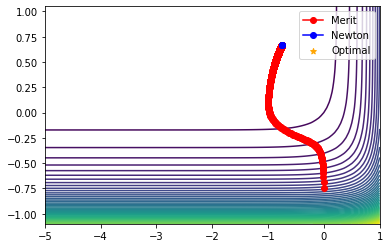

Starting point: [ 0.   -0.75]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501505167


<Figure size 432x288 with 0 Axes>

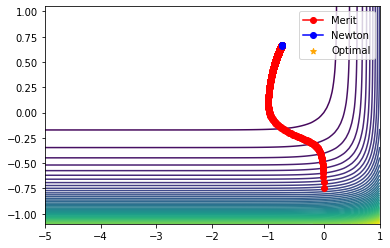

Starting point: [ 0.   -0.75]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.2123249354985347


<Figure size 432x288 with 0 Axes>

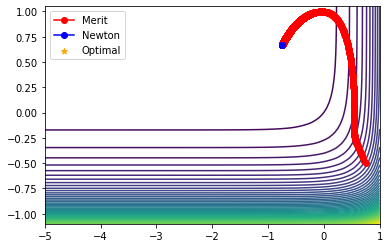

Starting point: [ 0.75 -0.5 ]	Final point: [-0.74833606  0.66331981]
Starting lambda: -1	Final lambda: -0.21232500268693585


<Figure size 432x288 with 0 Axes>

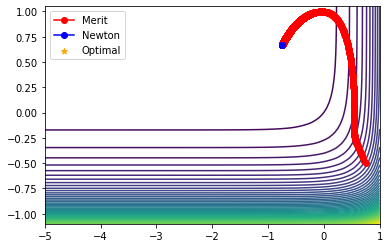

Starting point: [ 0.75 -0.5 ]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501483155


<Figure size 432x288 with 0 Axes>

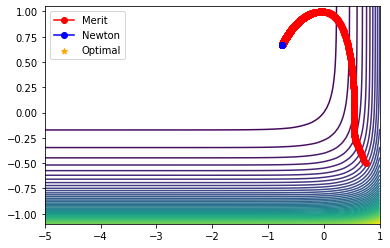

Starting point: [ 0.75 -0.5 ]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.2123249355029551


<Figure size 432x288 with 0 Axes>

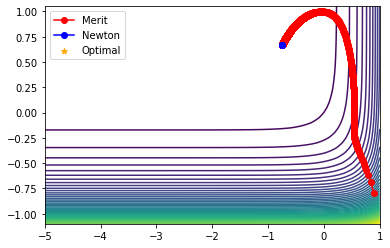

Starting point: [ 0.9 -0.8]	Final point: [-0.74833606  0.66331981]
Starting lambda: -1	Final lambda: -0.21232500268676438


<Figure size 432x288 with 0 Axes>

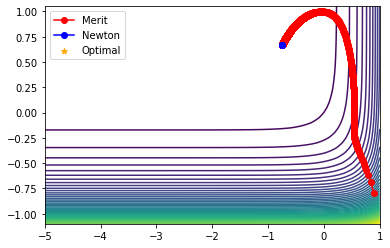

Starting point: [ 0.9 -0.8]	Final point: [-0.74833549  0.66332043]
Starting lambda: -0.21232390186241443	Final lambda: -0.21232493501483166


<Figure size 432x288 with 0 Axes>

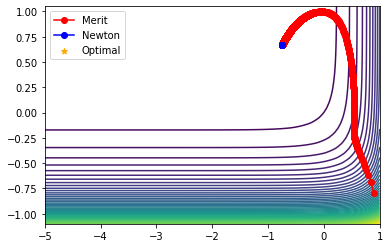

Starting point: [ 0.9 -0.8]	Final point: [-0.74833549  0.66332043]
Starting lambda: 2	Final lambda: -0.21232493550295356


In [16]:
for x_0 in x_list:
    for lamb_0 in lamb_list:
        x_end, lamb_end, merit_path, newton_path, _ = qop_merit(x_0, lamb_0, merit, grad_merit)
        plot_combined_path(f, merit_path, newton_path)
        print(f'Starting point: {x_0}\tFinal point: {x_end}')
        print(f'Starting lambda: {lamb_0}\tFinal lambda: {lamb_end}')

Overall, the solutions resemble the optimal.